=== Fixed Target Current IV Analysis ===
Target current: 0.020000 A

=== Available Current Range ===
=== Data Range Overview ===
Current range: [-0.022936, 0.546746] A
Total data points: 2000

Suggested target currents:
  1. 0.005548 A
  2. 0.133727 A
  3. 0.261905 A
  4. 0.390083 A
  5. 0.518262 A

=== Analyzing Fixed Target Current: 0.020000 A ===
Created output directory: iv_analysis_plots
=== Data Overview ===
Detected 20 measurement cycles with 100 points each
V1 range: [-1.500, -0.510] V
Current range: [-0.022936, 0.546746] A
Target current: 0.020000 A
Cycle 0: Found voltage = -1.294431 V for current = 0.020000 A
Cycle 1: Found voltage = -1.297725 V for current = 0.020000 A
Cycle 2: Found voltage = -1.297391 V for current = 0.020000 A
Cycle 3: Found voltage = -1.299543 V for current = 0.020000 A
Cycle 4: Found voltage = -1.298019 V for current = 0.020000 A
Cycle 5: Found voltage = -1.299258 V for current = 0.020000 A
Cycle 6: Found voltage = -1.298244 V for current = 0.020000 A
C

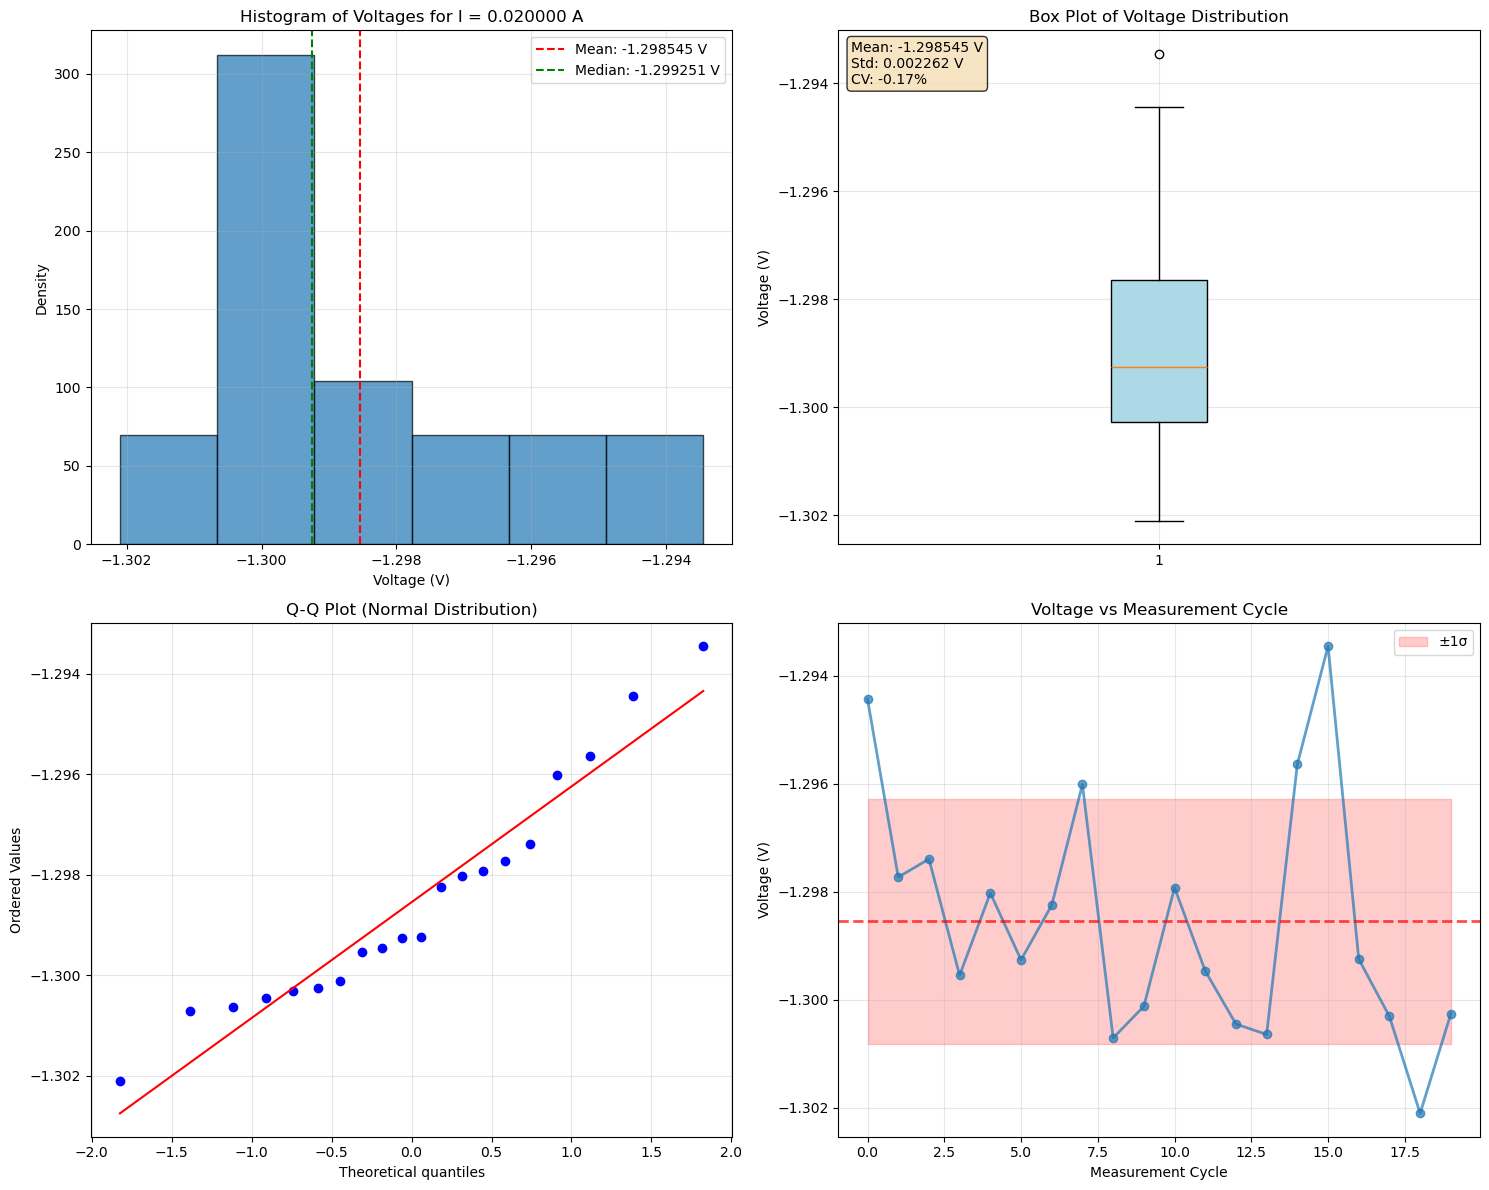


=== Results Summary ===
Found 20 voltage measurements
Voltage statistics: -1.298545 ± 0.002262 V
Coefficient of variation: -0.17%
Voltage data saved as: iv_analysis_plots/voltages_I_0.020000A.txt
Cycle data saved as: iv_analysis_plots/cycle_data_I_0.020000A.txt

=== Analysis Complete ===
All plots and data have been saved to the 'iv_analysis_plots' directory
Files generated:
- voltage_analysis_I_0.020000A.png
- voltages_I_0.020000A.txt
- cycle_data_I_0.020000A.txt


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import stats
import pandas as pd
import os

def load_iv_data(filename):
    """
    Load IV measurement data from file.
    Format: V2 V1 Current (3 columns)
    """
    data = np.loadtxt(filename)
    V2 = data[:, 0]  # Step voltage (outer loop)
    V1 = data[:, 1]  # Sweep voltage (inner loop)
    current = data[:, 2]  # Measured current
    return V2, V1, current

def find_voltages_for_current(V1_data, current_data, target_current, tolerance=None, method='interpolation'):
    """
    Find voltage values corresponding to a specific current value.
    
    Parameters:
    - V1_data: array of voltage values
    - current_data: array of current values
    - target_current: the current value to find voltages for
    - tolerance: tolerance for direct matching (if None, uses interpolation)
    - method: 'interpolation' or 'nearest'
    
    Returns:
    - voltages: array of voltage values corresponding to target_current
    """
    
    if method == 'nearest' and tolerance is not None:
        # Direct matching with tolerance
        mask = np.abs(current_data - target_current) <= tolerance
        return V1_data[mask]
    
    elif method == 'interpolation':
        # Use interpolation for more precise matching
        # Sort data by voltage for interpolation
        sort_indices = np.argsort(V1_data)
        V1_sorted = V1_data[sort_indices]
        current_sorted = current_data[sort_indices]
        
        # Check if target_current is within the range
        if target_current < np.min(current_sorted) or target_current > np.max(current_sorted):
            print(f"Warning: Target current {target_current} is outside the measured range "
                  f"[{np.min(current_sorted):.6f}, {np.max(current_sorted):.6f}]")
            return np.array([])
        
        # Interpolate to find voltage
        try:
            f = interpolate.interp1d(current_sorted, V1_sorted, kind='linear', 
                                   bounds_error=False, fill_value=np.nan)
            voltage = f(target_current)
            return np.array([voltage]) if not np.isnan(voltage) else np.array([])
        except:
            return np.array([])
    
    else:
        raise ValueError("Method must be 'interpolation' or 'nearest'")

def analyze_fixed_current(filename, target_current, tolerance=0.001, 
                         plot_results=True, save_plots=False, 
                         output_dir="iv_analysis_plots"):
    """
    Analyze statistical distribution of voltages for a fixed current value.
    
    Parameters:
    - filename: path to the data file
    - target_current: the specific current value to analyze
    - tolerance: tolerance for current matching (only for nearest method)
    - plot_results: whether to display plots
    - save_plots: whether to save plots to files
    - output_dir: directory to save plots
    
    Returns:
    - results: dictionary containing statistical analysis
    """
    
    # Create output directory if saving plots
    if save_plots:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created output directory: {output_dir}")
    
    # Load data
    V2, V1, current = load_iv_data(filename)
    
    # Find the cycle length by looking for repeated V1 values
    unique_V1 = np.unique(V1)
    cycle_length = len(unique_V1)
    total_cycles = len(V1) // cycle_length
    
    print(f"=== Data Overview ===")
    print(f"Detected {total_cycles} measurement cycles with {cycle_length} points each")
    print(f"V1 range: [{np.min(V1):.3f}, {np.max(V1):.3f}] V")
    print(f"Current range: [{np.min(current):.6f}, {np.max(current):.6f}] A")
    print(f"Target current: {target_current:.6f} A")
    
    # Check if target current is in valid range
    if target_current < np.min(current) or target_current > np.max(current):
        print(f"\nERROR: Target current {target_current:.6f} A is outside the measured range!")
        print(f"Please choose a current between {np.min(current):.6f} and {np.max(current):.6f} A")
        return None
    
    all_voltages = []
    cycle_info = []
    
    # Analyze each measurement cycle
    for cycle_idx in range(total_cycles):
        start_idx = cycle_idx * cycle_length
        end_idx = start_idx + cycle_length
        
        if end_idx > len(V1):  # Handle incomplete last cycle
            end_idx = len(V1)
        
        V1_cycle = V1[start_idx:end_idx]
        current_cycle = current[start_idx:end_idx]
        
        # Find voltage for target current in this cycle
        voltage = find_voltages_for_current(V1_cycle, current_cycle, 
                                          target_current, method='interpolation')
        
        if len(voltage) > 0 and not np.isnan(voltage[0]):
            all_voltages.append(voltage[0])
            cycle_info.append({
                'cycle': cycle_idx,
                'voltage': voltage[0],
                'current': target_current
            })
            print(f"Cycle {cycle_idx}: Found voltage = {voltage[0]:.6f} V for current = {target_current:.6f} A")
    
    all_voltages = np.array(all_voltages)
    
    if len(all_voltages) == 0:
        print(f"\nNo voltage values found for current = {target_current:.6f} A")
        print(f"Try a current value between {np.min(current):.6f} and {np.max(current):.6f} A")
        return None
    
    if len(all_voltages) == 1:
        print(f"\nOnly one voltage value found. Cannot calculate variance.")
        print(f"Found voltage: {all_voltages[0]:.6f} V")
        return {
            'target_current': target_current,
            'voltages': all_voltages,
            'n_measurements': 1,
            'mean': all_voltages[0],
            'std': 0.0,
            'variance': 0.0,
            'min': all_voltages[0],
            'max': all_voltages[0],
            'median': all_voltages[0],
            'range': 0.0,
            'cv': 0.0,
            'shapiro_stat': None,
            'shapiro_p': None,
            'cycle_info': cycle_info
        }
    
    # Calculate statistics (safe for multiple values)
    mean_voltage = np.mean(all_voltages)
    
    # Safe calculation of standard deviation
    if len(all_voltages) > 1:
        std_voltage = np.std(all_voltages, ddof=1)  # Sample standard deviation
        variance = std_voltage**2
    else:
        std_voltage = 0.0
        variance = 0.0
    
    min_voltage = np.min(all_voltages)
    max_voltage = np.max(all_voltages)
    median_voltage = np.median(all_voltages)
    
    # Statistical tests (only if we have enough data)
    shapiro_stat, shapiro_p = None, None
    if len(all_voltages) >= 3:
        try:
            shapiro_stat, shapiro_p = stats.shapiro(all_voltages)
        except:
            shapiro_stat, shapiro_p = None, None
    
    results = {
        'target_current': target_current,
        'voltages': all_voltages,
        'n_measurements': len(all_voltages),
        'mean': mean_voltage,
        'std': std_voltage,
        'variance': variance,
        'min': min_voltage,
        'max': max_voltage,
        'median': median_voltage,
        'range': max_voltage - min_voltage,
        'cv': (std_voltage / mean_voltage * 100) if mean_voltage != 0 and std_voltage != 0 else 0,
        'shapiro_stat': shapiro_stat,
        'shapiro_p': shapiro_p,
        'cycle_info': cycle_info
    }
    
    # Print results
    print(f"\n=== Statistical Analysis for Current = {target_current:.6f} A ===")
    print(f"Number of measurements: {results['n_measurements']}")
    print(f"Mean voltage: {results['mean']:.6f} V")
    
    if results['n_measurements'] > 1:
        print(f"Standard deviation: ±{results['std']:.6f} V")
        print(f"Variance: {results['variance']:.8f} V²")
        print(f"Range: [{results['min']:.6f}, {results['max']:.6f}] V")
        print(f"Median: {results['median']:.6f} V")
        print(f"Coefficient of variation: {results['cv']:.2f}%")
        
        if shapiro_p is not None:
            print(f"Shapiro-Wilk normality test: p = {shapiro_p:.4f}")
            if shapiro_p > 0.05:
                print("  -> Data appears to be normally distributed (p > 0.05)")
            else:
                print("  -> Data may not be normally distributed (p ≤ 0.05)")
    else:
        print("Only one measurement found - no statistical analysis possible")
    
    # Create plots only if we have enough data
    if (plot_results or save_plots) and len(all_voltages) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        ax1, ax2, ax3, ax4 = axes.flatten()
        
        # Histogram
        n_bins = min(20, max(5, len(all_voltages)//3))
        ax1.hist(all_voltages, bins=n_bins, alpha=0.7, edgecolor='black', density=True)
        ax1.axvline(mean_voltage, color='red', linestyle='--', 
                   label=f'Mean: {mean_voltage:.6f} V')
        ax1.axvline(median_voltage, color='green', linestyle='--', 
                   label=f'Median: {median_voltage:.6f} V')
        ax1.set_xlabel('Voltage (V)')
        ax1.set_ylabel('Density')
        ax1.set_title(f'Histogram of Voltages for I = {target_current:.6f} A')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Box plot
        bp = ax2.boxplot(all_voltages, vert=True, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        ax2.set_ylabel('Voltage (V)')
        ax2.set_title('Box Plot of Voltage Distribution')
        ax2.grid(True, alpha=0.3)
        
        # Add statistics text to box plot
        stats_text = f'Mean: {mean_voltage:.6f} V\nStd: {std_voltage:.6f} V\nCV: {results["cv"]:.2f}%'
        ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Q-Q plot for normality check (only if enough data)
        if len(all_voltages) >= 3:
            try:
                stats.probplot(all_voltages, dist="norm", plot=ax3)
                ax3.set_title('Q-Q Plot (Normal Distribution)')
                ax3.grid(True, alpha=0.3)
            except:
                ax3.text(0.5, 0.5, 'Error creating Q-Q plot', 
                        ha='center', va='center', transform=ax3.transAxes)
        else:
            ax3.text(0.5, 0.5, 'Not enough data for Q-Q plot', 
                    ha='center', va='center', transform=ax3.transAxes)
        
        # Time series plot (measurement order)
        cycle_numbers = [info['cycle'] for info in cycle_info]
        cycle_voltages = [info['voltage'] for info in cycle_info]
        
        ax4.plot(cycle_numbers, cycle_voltages, 'o-', alpha=0.7, linewidth=2, markersize=6)
        ax4.axhline(mean_voltage, color='red', linestyle='--', alpha=0.7, linewidth=2)
        
        if std_voltage > 0:
            ax4.fill_between(cycle_numbers, 
                            mean_voltage - std_voltage, 
                            mean_voltage + std_voltage, 
                            alpha=0.2, color='red', label='±1σ')
            ax4.legend()
        
        ax4.set_xlabel('Measurement Cycle')
        ax4.set_ylabel('Voltage (V)')
        ax4.set_title('Voltage vs Measurement Cycle')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the plot if requested
        if save_plots:
            plot_filename = f"{output_dir}/voltage_analysis_I_{target_current:.6f}A.png"
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            print(f"Plot saved as: {plot_filename}")
        
        if plot_results:
            plt.show()
        else:
            plt.close()
    
    elif (plot_results or save_plots) and len(all_voltages) == 1:
        print("Only one data point found - cannot create statistical plots")
    
    return results

def save_voltage_data(results, output_dir="iv_analysis_plots"):
    """
    Save the extracted voltage data to text files for further analysis.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    if results is not None and 'voltages' in results:
        # Save voltage values
        voltage_filename = f"{output_dir}/voltages_I_{results['target_current']:.6f}A.txt"
        np.savetxt(voltage_filename, results['voltages'], 
                  header=f"Voltage values (V) for current = {results['target_current']:.6f} A\n"
                         f"Number of measurements: {results['n_measurements']}\n"
                         f"Mean: {results['mean']:.6f} V\n"
                         f"Std: {results['std']:.6f} V\n"
                         f"Variance: {results['variance']:.8f} V²",
                  fmt='%.8f')
        print(f"Voltage data saved as: {voltage_filename}")
        
        # Save cycle information
        if 'cycle_info' in results and results['cycle_info']:
            cycle_filename = f"{output_dir}/cycle_data_I_{results['target_current']:.6f}A.txt"
            with open(cycle_filename, 'w') as f:
                f.write("# Cycle\tVoltage(V)\tCurrent(A)\n")
                for info in results['cycle_info']:
                    f.write(f"{info['cycle']}\t{info['voltage']:.8f}\t{info['current']:.8f}\n")
            print(f"Cycle data saved as: {cycle_filename}")

def suggest_current_values(filename, n_suggestions=5):
    """
    Suggest good target current values based on the data range.
    """
    V2, V1, current = load_iv_data(filename)
    min_current = np.min(current)
    max_current = np.max(current)
    
    print(f"=== Data Range Overview ===")
    print(f"Current range: [{min_current:.6f}, {max_current:.6f}] A")
    print(f"Total data points: {len(current)}")
    
    # Suggest evenly spaced values within the range
    margin = (max_current - min_current) * 0.05  # 5% margin
    suggested_currents = np.linspace(min_current + margin, max_current - margin, n_suggestions)
    
    print(f"\nSuggested target currents:")
    for i, curr in enumerate(suggested_currents):
        print(f"  {i+1}. {curr:.6f} A")
    
    return suggested_currents

# Example usage
if __name__ == "__main__":
    # Configuration
    filename = "data_IV_202507041217_iter20.txt"
    output_directory = "iv_analysis_plots"
    
    # MODIFY THIS LINE TO SET YOUR FIXED TARGET CURRENT
    FIXED_TARGET_CURRENT = 2.0e-2  # Set your desired current value here (in Amperes)
    
    print("=== Fixed Target Current IV Analysis ===")
    print(f"Target current: {FIXED_TARGET_CURRENT:.6f} A")
    
    # Optional: Check available current range and get suggestions
    print("\n=== Available Current Range ===")
    suggestions = suggest_current_values(filename)
    
    # Analyze the fixed target current
    print(f"\n=== Analyzing Fixed Target Current: {FIXED_TARGET_CURRENT:.6f} A ===")
    
    result = analyze_fixed_current(filename, FIXED_TARGET_CURRENT, 
                                  tolerance=0.001, plot_results=True, 
                                  save_plots=True, output_dir=output_directory)
    
    if result is not None:
        print(f"\n=== Results Summary ===")
        print(f"Found {result['n_measurements']} voltage measurements")
        if result['n_measurements'] > 1:
            print(f"Voltage statistics: {result['mean']:.6f} ± {result['std']:.6f} V")
            print(f"Coefficient of variation: {result['cv']:.2f}%")
        else:
            print(f"Single voltage value: {result['mean']:.6f} V")
        
        # Save additional data
        save_voltage_data(result, output_directory)
        
        print(f"\n=== Analysis Complete ===")
        print(f"All plots and data have been saved to the '{output_directory}' directory")
        print("Files generated:")
        print(f"- voltage_analysis_I_{FIXED_TARGET_CURRENT:.6f}A.png")
        print(f"- voltages_I_{FIXED_TARGET_CURRENT:.6f}A.txt")
        print(f"- cycle_data_I_{FIXED_TARGET_CURRENT:.6f}A.txt")
    else:
        print("\nAnalysis failed. Please check the target current value.")